In [1]:
from tqdm.notebook import tnrange

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sigmaclip as sigmaclip
import astropy.constants as const
from tqdm.notebook import tnrange

from function import med_n_lim

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading SYSREM results

numorder, numframe, numwv, n_sys = 22, 56, 4080, 10

#for propagation error
flux_dat = np.zeros((numorder,n_sys+1,numframe,numwv))
error_dat = flux_dat.copy()
wave_dat = flux_dat.copy()
a_dat = np.zeros((numorder,n_sys+1,numframe))
c_dat = np.zeros((numorder,n_sys+1,numwv))

for order in range(numorder):
    for sysiter in range(n_sys+1):

    #reading hdf5 file for each SYSREM iteration (default binmedfil=151)
        with h5py.File('data/hdf5/HD149026b-after-#'+str(sysiter)+'-SYSREM-iteration-sys.hdf5', 'r') as h5f_raw:

            flux_dat[order,sysiter] = h5f_raw['flux-order-'+str(order)][()]
            error_dat[order,sysiter] = h5f_raw['error-poisson-order-'+str(order)][()]
            wave_dat[order,sysiter] = h5f_raw['wv-vac-order-'+str(order)][()]
            airmass = h5f_raw['airmass'][()]
            rvcor = h5f_raw['rv_cor'][()]
            bjd = h5f_raw['bjd'][()]
            mjd = h5f_raw['mjd'][()]
            phase = h5f_raw['phase'][()]
            rel_phase = h5f_raw['rel_phase'][()]
            hour_phase = h5f_raw['hour_phase'][()]
            exptime = h5f_raw['exp_time'][()]
            out_transit_mask = h5f_raw['out_transit_mask'][()]
            transit_weight = h5f_raw['transit_weight'][()]
            carm_order = h5f_raw['carm_order'][()]
            contact_index = h5f_raw['contact_index'][()]

            if sysiter != 0:
                a_dat[order,sysiter-1] = h5f_raw['a-coeff-order-'+str(order)][()]
                c_dat[order,sysiter-1] = h5f_raw['c-coeff-order-'+str(order)][()]

In [3]:
def pre_processing(wave,flux,error,a_coeff,wave_model,flux_model,Kp_val,Vrest_val,A_val,sys_iter,V_sys,
                   carm_order=carm_order,phase=phase,rvcor=rvcor,out_transit_mask=out_transit_mask,transit_weight=transit_weight):

    Ndata = np.empty((len(carm_order)))
    K1_loop = np.empty((len(carm_order),len(rvcor)))
    K2_loop = np.empty((len(carm_order),len(Vrest_val),len(Kp_val),len(rvcor)))
    CC_loop = np.empty((len(carm_order),len(Vrest_val),len(Kp_val),len(rvcor)))

    for order_idx in tnrange(len(carm_order)):

        wave_obs = wave[order_idx][sys_iter]
        flux_obs = flux[order_idx][sys_iter]
        error_obs = error[order_idx][sys_iter]
        a_obs = a_coeff[order_idx][:sys_iter]

        K1_loop[order_idx] = np.nansum(flux_obs ** 2 / error_obs ** 2, axis=1)
        Ndata[order_idx] = len(flux_obs[0])

        masktemp = (wave_model > wave_obs[0][0] - 20) * (wave_model < wave_obs[0][-1] + 20)
        wv_mod, flux_mod = wave_model[masktemp], flux_model[masktemp]

        # Diagonal matrix for 1/error terms
        error_obs_temp = error_obs.copy()
        error_obs_temp[error_obs_temp == np.inf] = np.nan
        error_hat = np.nanmean(error_obs_temp, axis=1)
        error_hat_mat = np.diag(1 / error_hat)

        # Bias term for the basis vectors U
        z = np.ones((len(phase), 1))
        U = np.append(a_obs.T, z, axis=1)

        lambU = np.dot(error_hat_mat, U)
        UlambU = np.dot(U, np.linalg.pinv(lambU)) # function for the Moore-Penrose inverse

        for idv in range(len(Vrest_val)):
            for idk in range(len(Kp_val)):

                RV_planet = Kp_val[idk] * np.sin(2 * np.pi * phase) + V_sys - rvcor + Vrest_val[idv]

                # Doppler-shifting the model to the desired RV
                wv_mod_shifted = wave_obs[0][np.newaxis, :] / (1 + RV_planet * 1000 / const.c.value)[:, np.newaxis]
                flux_mod_shifted = np.interp(wv_mod_shifted, wv_mod, flux_mod)

                ######################### Pre-processing ###############################

                # Mean subtract the model to be able to strecth and squeeze it by the transit weighting
                mean_temp = np.mean(flux_mod_shifted, axis=1)
                flux_mod_shifted -= mean_temp[:,None]

                # Weighting the model with transit light curve
                flux_mod_shifted *= transit_weight[:, np.newaxis]

                # Adding back the mean to bring back the model to the original shape but with weighting applied
                flux_mod_shifted += mean_temp[:,None]

                # Median division
                flux_mod_shifted /= np.median(flux_mod_shifted, axis=0)[None,:]
                flux_mod_shifted -= 1

                # Mimic mean normalizing right before SYSREM
                flux_mod_shifted -= np.mean(flux_mod_shifted, axis=0)

                # Compute the model basis vectors M'
                lambM = np.dot(error_hat_mat, flux_mod_shifted)
                M_aks = np.dot(UlambU, lambM)

                # Subtract model with the basis vectors
                mod_proc = flux_mod_shifted - M_aks

                # putting the Doppler-shifted model into common continuum level
                mod_proc -= np.nanmedian(mod_proc,axis=1)[:,np.newaxis]
                maskpix = error_obs[0]!=np.inf
                for frame in range(error_obs.shape[0]):
                    flux_obs[frame][maskpix==True] = flux_obs[frame][maskpix] - np.nanmedian(flux_obs[frame][maskpix])

                # Calculating the summation terms in the chi^2 equation
                K2_loop[order_idx,idv,idk] = np.nansum(mod_proc ** 2 / error_obs ** 2, axis=1)
                CC_loop[order_idx,idv,idk] = np.nansum(mod_proc * flux_obs / error_obs ** 2, axis=1)

    # Summing over the orders
    K1_total = np.sum(K1_loop, axis=0)
    K2_total = np.sum(K2_loop, axis=0)
    CC_total = np.sum(CC_loop, axis=0)
    Ndata_total = np.sum(Ndata)
    
    # Summing over in-transit frames
    # No shifting needed before summing over frames as it is already in the expected RV path for the given combination of Kp and Vsys
    out_transit_mask_temp = np.tile(out_transit_mask,(K2_total.shape[0],K2_total.shape[1],1))
    K1_final = K1_total[out_transit_mask > 0].sum()  # K1 is constant as it only depends on the data, not on RV (Kp and Vrest values) 
    K2_final = np.where(out_transit_mask_temp > 0, K2_total, False).sum(axis=2)
    CC_final = np.where(out_transit_mask_temp > 0, CC_total, False).sum(axis=2)
    Ndata_total_summed = Ndata_total * len(out_transit_mask[out_transit_mask > 0])

    # Compute chi^2
    chi2_total = K1_final + A_val[:, np.newaxis, np.newaxis] ** 2. * (K2_final.T)[np.newaxis, ...] - \
                    2. * A_val[:, np.newaxis, np.newaxis] * (CC_final.T)[np.newaxis, ...]   # I transpose K2 and CC just for plotting necessity (it is not crucial)

    # Compute likelihood
    logL = -Ndata_total_summed / 2 * np.log(chi2_total / Ndata_total_summed)
    Likelihood_F = np.exp(logL - np.max(logL))

    return K1_loop,K2_loop,CC_loop,Ndata,Likelihood_F

In [4]:
# reading model
flux_model = pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_vorbplanet_flux_nonnormalized.pkl')
wave_model = pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalsep010_abundCE_vorbplanet_wave_nonnormalized.pkl')

In [5]:
# pre-processingm

Kp_sample = np.arange(50,250,1.6)       # in km/s
Vrest_sample = np.arange(-20.,20.,0.1)     # in km/s
A_sample = np.arange(0.,3.,0.01)
sys_iter = 1
V_sys = -17.91

K1_loop,K2_loop,CC_loop,Ndata,Likelihood_F = pre_processing(wave_dat,flux_dat,error_dat,a_dat,wave_model,flux_model,Kp_sample,Vrest_sample,A_sample,sys_iter,V_sys)
# L_F = pre_processing_1(flux_dat,error_dat,wave_dat,a_dat,wave_model,flux_model,Kp_sample,Vrest_sample,A_sample,sys_iter,carm_order,out_transit_mask,phase,rvcor,transit_weight)

  0%|          | 0/22 [00:00<?, ?it/s]

In [10]:
# # saving results to HDF5 files

# with h5py.File('data/hdf5/3D_grid_search_Asample0d3d001.hdf5', 'w') as h5f_raw:

#     h5f_raw.create_dataset('K1_loop',data=K1_loop)
#     h5f_raw.create_dataset('K2_loop',data=K2_loop)
#     h5f_raw.create_dataset('CC_loop',data=CC_loop)
#     h5f_raw.create_dataset('Ndata',data=Ndata)
#     h5f_raw.create_dataset('Likelihood_F',data=Likelihood_F)

In [27]:
# # reading grid search results

# with h5py.File('data/hdf5/3D_grid_search_Asample0d3d001.hdf5.hdf5', 'r') as h5f_raw:

#     Likelihood_F = h5f_raw['Likelihood_F'][()]
#     Ndata = h5f_raw['Ndata'][()]
#     K1_loop = h5f_raw['K1_loop'][()]
#     K2_loop = h5f_raw['K2_loop'][()]
#     CC_loop = h5f_raw['CC_loop'][()]

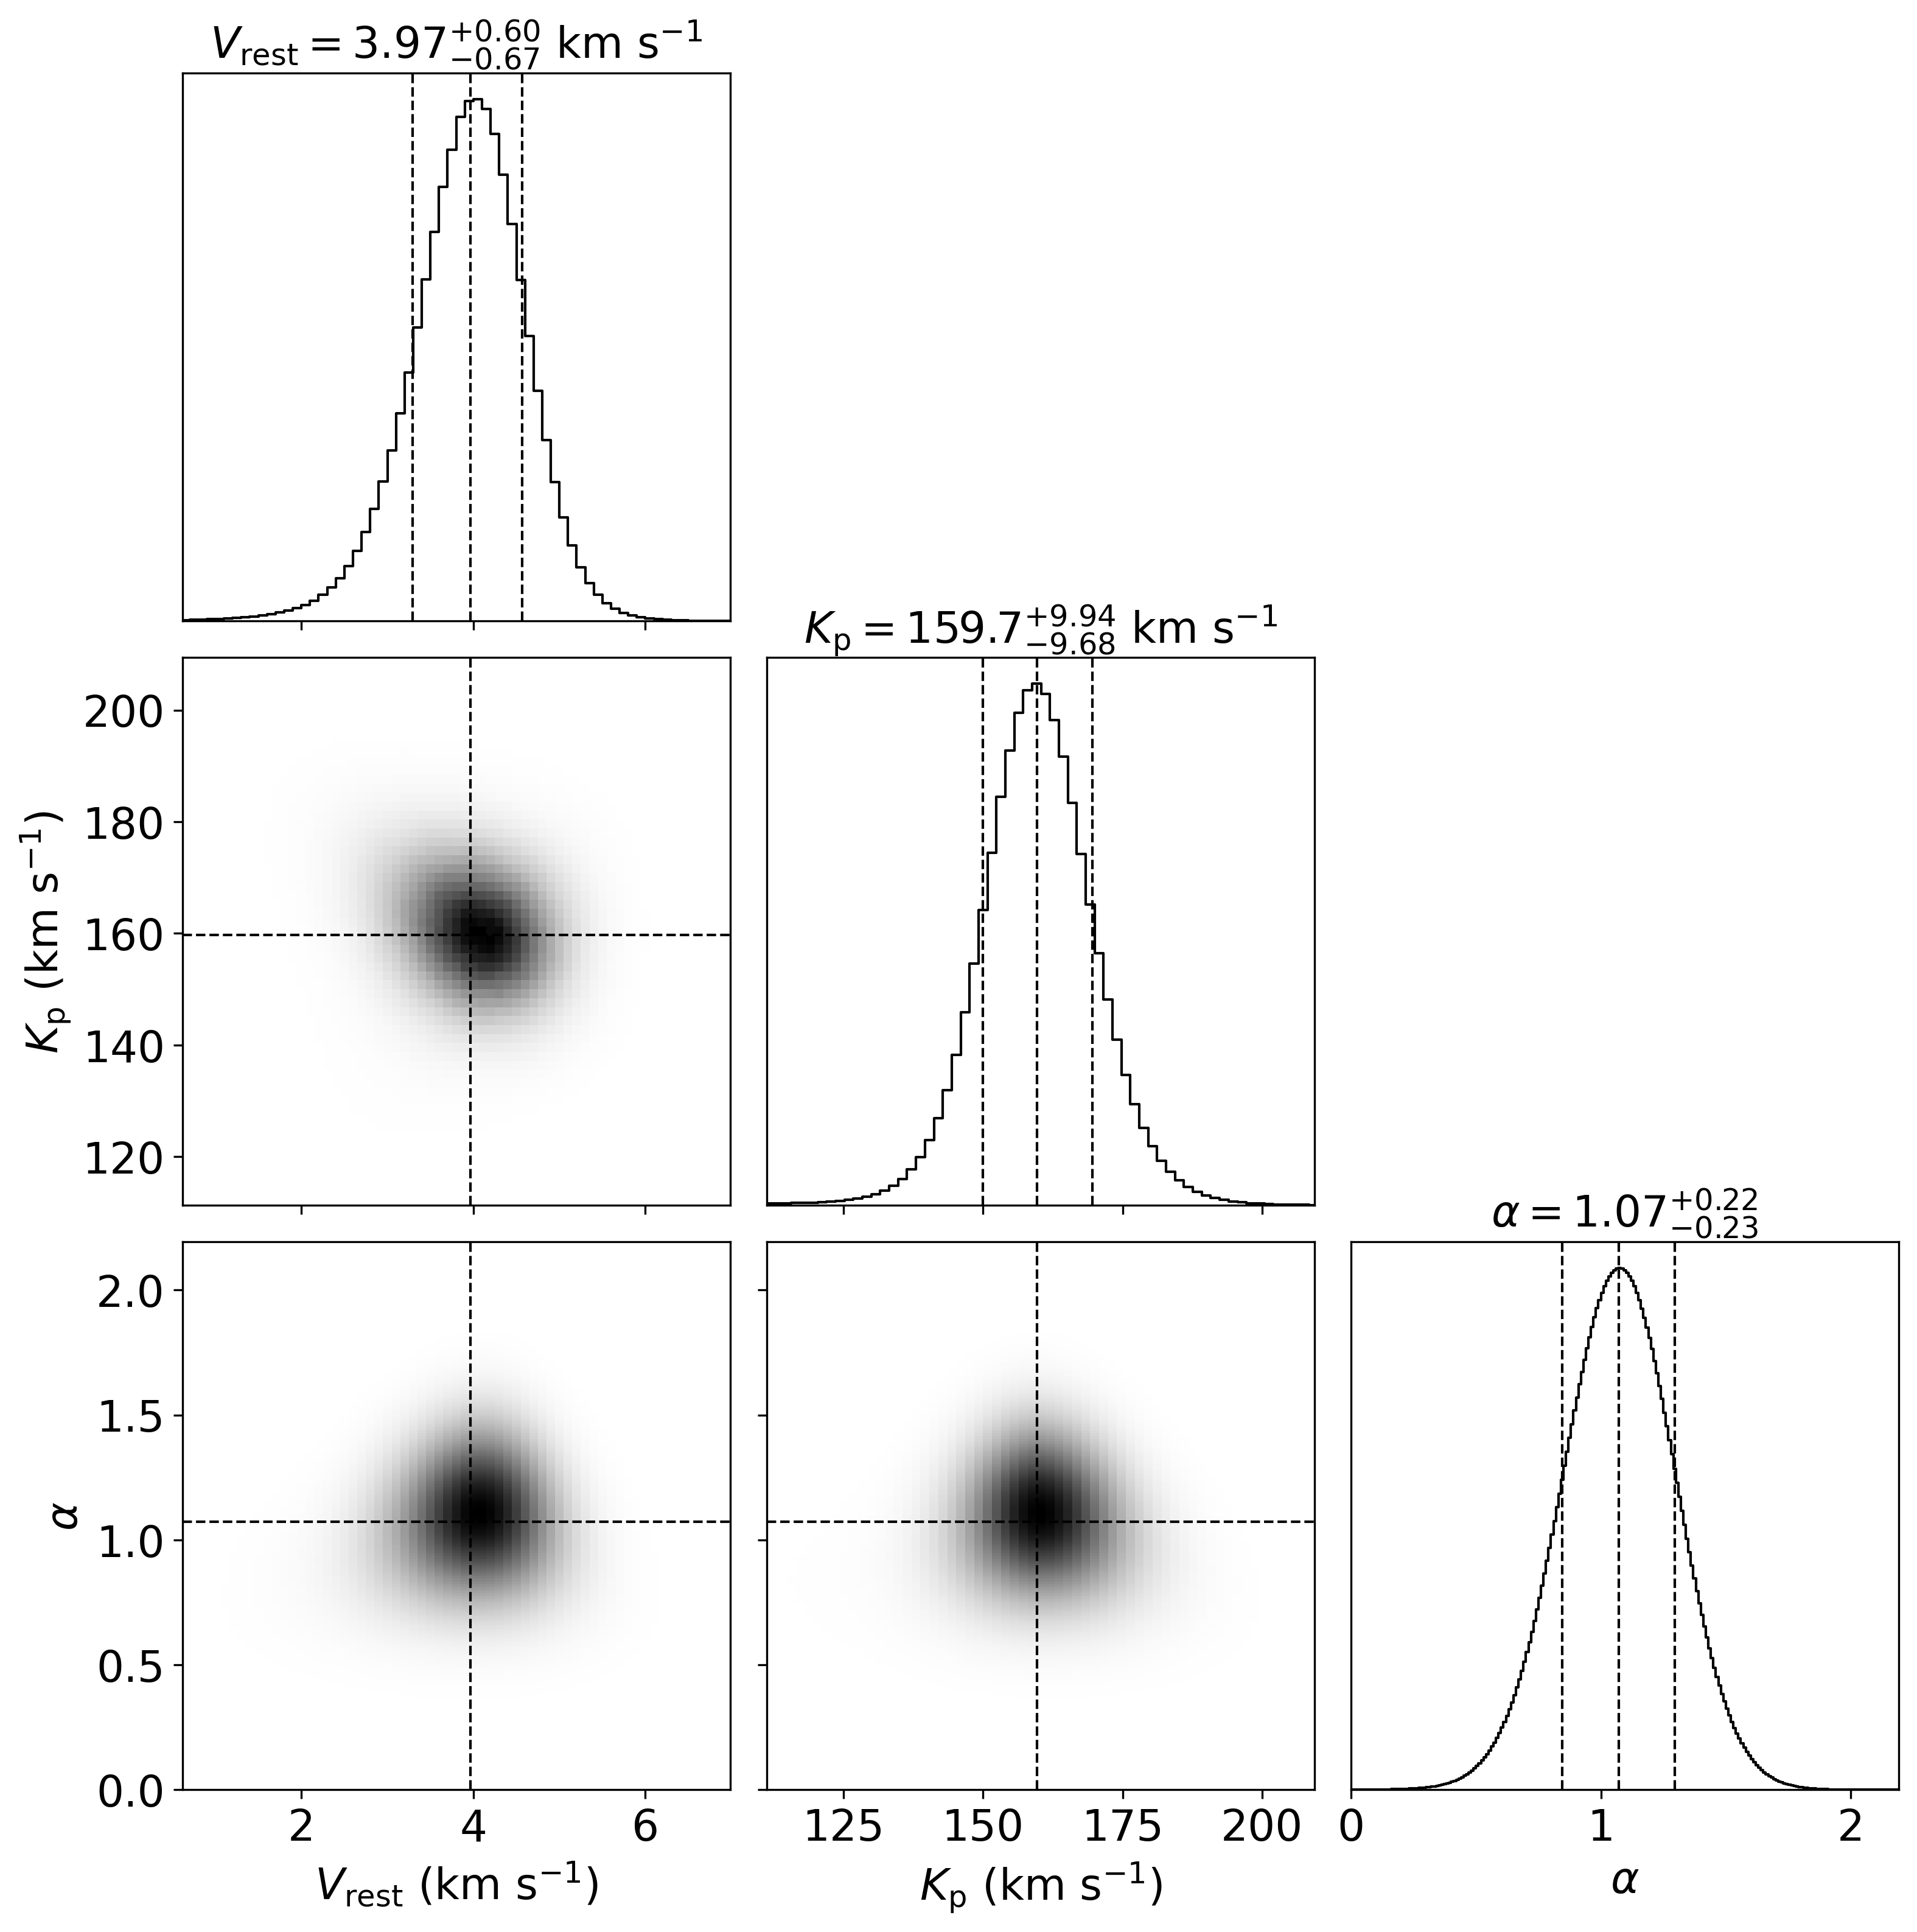

<Figure size 640x480 with 0 Axes>

In [9]:
lbl = 17

# Marginilising Kp, Vsys, and alpha
Kp_marg = Likelihood_F.sum(axis=(0, 2))  # for Kp
Vsys_marg = Likelihood_F.sum(axis=(0, 1))  # for Vsys
A_marg = Likelihood_F.sum(axis=(1, 2))  # for alpha

# Conditional likelihood
A_cond = Likelihood_F[:, np.argmax(Kp_marg), np.argmax(Vsys_marg)]

std_A_low, med_A, std_A_high = med_n_lim(A_sample, A_marg)
std_vsys_low, med_vsys, std_vsys_high = med_n_lim(Vrest_sample, Vsys_marg)
std_kp_low, med_kp, std_kp_high = med_n_lim(Kp_sample, Kp_marg)
std_Ac_low, med_Ac, std_Ac_high = med_n_lim(A_sample, A_cond)

# Plotting the marginalised likelihood
axes_alpvsys = [0, 0, 0.3, 0.3]
axes_alpkp = [0 + 0.3 + 0.02, 0, 0.3, 0.3]
axes_kpvsys = [0, 0 + 0.3 + 0.02, 0.3, 0.3]
axes_vsysmarg = [0, 0 + 0.3 + 0.3 + 0.04, 0.3, 0.3]
axes_kpmarg = [0 + 0.3 + 0.02, 0 + 0.3 + 0.02, 0.3, 0.3]
axes_alpmarg = [0 + 0.3 + 0.3 + 0.02 + 0.02, 0, 0.3, 0.3]

fig = plt.figure(figsize=(10, 10),dpi=300)
vsysalp = plt.axes(axes_alpvsys)
kpalp = plt.axes(axes_alpkp)
kpvsys = plt.axes(axes_kpvsys)
vsysmarg = plt.axes(axes_vsysmarg)
kpmarg = plt.axes(axes_kpmarg)
alpmarg = plt.axes(axes_alpmarg)

vsysalp.set_ylabel(r"$\alpha$",fontsize=lbl)
vsysalp.set_xlabel(r"$V_\mathrm{rest}$ (km s$^{-1}$)",fontsize=lbl)
kpalp.set_xlabel(r"$K_\mathrm{p}$ (km s$^{-1}$)",fontsize=lbl)
kpvsys.set_ylabel(r"$K_\mathrm{p}$ (km s$^{-1}$)",fontsize=lbl)
alpmarg.set_xlabel(r"$\alpha$",fontsize=lbl)

kpalp.set_yticklabels([])
kpvsys.set_xticklabels([])
alpmarg.set_yticklabels([])
kpmarg.set_yticklabels([])
kpmarg.set_xticklabels([])
vsysmarg.set_xticklabels([])

vsysmarg.step(Vrest_sample, Vsys_marg, c="black", lw=1)
vsysmarg.set_xlim([med_vsys - 5 * abs(std_vsys_low), med_vsys + 5 * abs(std_vsys_high)])
vsysmarg.set_ylim(bottom=0)
vsysmarg.axvline(x=med_vsys, lw=1, ls='--', c='black')
vsysmarg.axvline(x=med_vsys - 1 * abs(std_vsys_low), lw=1, ls='--', c='black')
vsysmarg.axvline(x=med_vsys + 1 * abs(std_vsys_high), lw=1, ls='--', c='black')
vsysmarg.set_title(r'$V_\mathrm{rest} = $' + str(round(med_vsys, 2)) + r'$^{+' + str("%.2f" % std_vsys_high) + '}_{-' + str(
    "%.2f" % abs(std_vsys_low)) + '}$ km s$^{-1}$',fontsize=lbl)
vsysmarg.tick_params(axis='both', which='major', labelsize=lbl)

norm_like_vsys = Likelihood_F.sum(axis=1)
vsysalp.pcolormesh(Vrest_sample, A_sample, norm_like_vsys / np.max(norm_like_vsys), cmap="binary")
vsysalp.set_xlim([med_vsys - 5 * abs(std_vsys_low), med_vsys + 5 * abs(std_vsys_high)])
vsysalp.set_ylim([0, med_A + 5 * abs(std_A_high)])
vsysalp.tick_params(axis='both', which='major', labelsize=lbl)

kpmarg.step(Kp_sample, Kp_marg, c="black", lw=1)
kpmarg.set_xlim([med_kp - 5 * abs(std_kp_low), med_kp + 5 * abs(std_kp_high)])
kpmarg.set_ylim(bottom=0)
kpmarg.axvline(x=med_kp, lw=1, ls='--', c='black')
kpmarg.axvline(x=med_kp - 1 * abs(std_kp_low), lw=1, ls='--', c='black')
kpmarg.axvline(x=med_kp + 1 * abs(std_kp_high), lw=1, ls='--', c='black')
kpmarg.set_title(r'$K_\mathrm{p} = $' + str(round(med_kp, 2)) + r'$^{+' + str("%.2f" % std_kp_high) + '}_{-' + str(
    "%.2f" % abs(std_kp_low)) + '}$ km s$^{-1}$',fontsize=lbl)
kpmarg.tick_params(axis='both', which='major', labelsize=lbl)

norm_like_kp = Likelihood_F.sum(axis=2)
kpalp.pcolormesh(Kp_sample, A_sample, norm_like_kp / np.max(norm_like_kp), cmap="binary")
kpalp.set_xlim([med_kp - 5 * abs(std_kp_low), med_kp + 5 * abs(std_kp_high)])
kpalp.set_ylim([0, med_A + 5 * abs(std_A_high)])
kpalp.tick_params(axis='both', which='major', labelsize=lbl)

norm_like_kpvsys = Likelihood_F.sum(axis=0)
# kpvsys.contourf(Vrest_sample, Kp_sample, norm_like_kpvsys / np.max(norm_like_kpvsys), cmap='viridis',levels=np.concatenate([[0], V, [H.max()]]))
kpvsys.pcolormesh(Vrest_sample, Kp_sample, norm_like_kpvsys / np.max(norm_like_kpvsys), cmap="binary")
kpvsys.set_xlim([med_vsys - 5 * abs(std_vsys_low), med_vsys + 5 * abs(std_vsys_high)])
kpvsys.set_ylim([med_kp - 5 * abs(std_kp_low), med_kp + 5 * abs(std_kp_high)])
kpvsys.tick_params(axis='both', which='major', labelsize=lbl)

alpmarg.step(A_sample, A_marg, c='black', lw=1)
alpmarg.axvline(x=med_A, lw=1, ls='--', c='black')
alpmarg.axvline(x=med_A - 1 * abs(std_A_low), lw=1, ls='--', c='black')
alpmarg.axvline(x=med_A + 1 * abs(std_A_high), lw=1, ls='--', c='black')
alpmarg.set_xlim([0, med_A + 5 * abs(std_A_high)])
alpmarg.set_ylim(bottom=0)
alpmarg.set_title(r'$\alpha = $' + str(round(med_A, 2)) + r'$^{+' + str("%.2f" % std_A_high) + '}_{-' + str(
    "%.2f" % abs(std_A_low)) + '}$',fontsize=lbl)
alpmarg.tick_params(axis='both', which='major', labelsize=lbl)

vsysalp.axvline(x=med_vsys, lw=1, ls='--', c='black')
vsysalp.axhline(y=med_A, lw=1, ls='--', c='black')
kpalp.axvline(x=med_kp, lw=1, ls='--', c='black')
kpalp.axhline(y=med_A, lw=1, ls='--', c='black')
kpvsys.axvline(x=med_vsys, lw=1, ls='--', c='black')
kpvsys.axhline(y=med_kp, lw=1, ls='--', c='black')

kpmarg.tick_params(left=False)
vsysmarg.tick_params(left=False, labelleft=False)
alpmarg.tick_params(left=False)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig("figures/grid_search_3D.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
plt.show(block=False)
plt.clf()